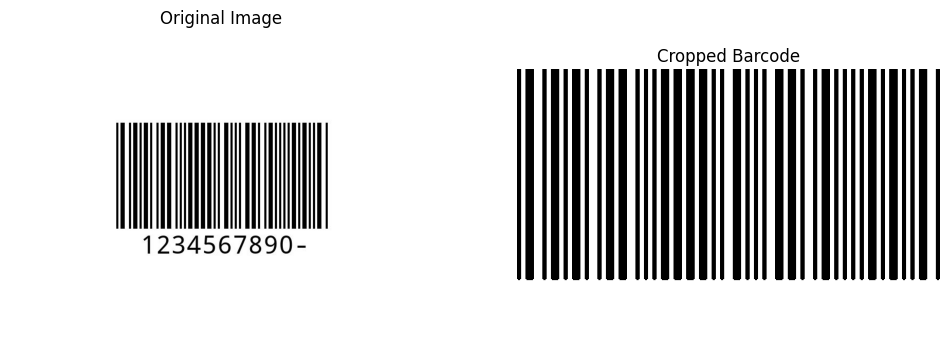

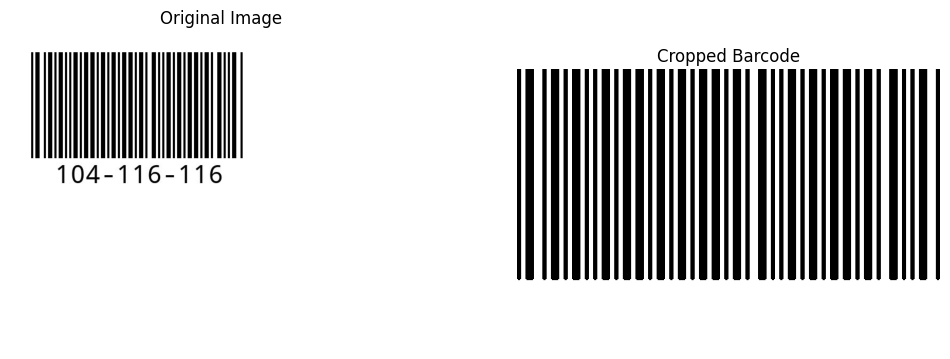

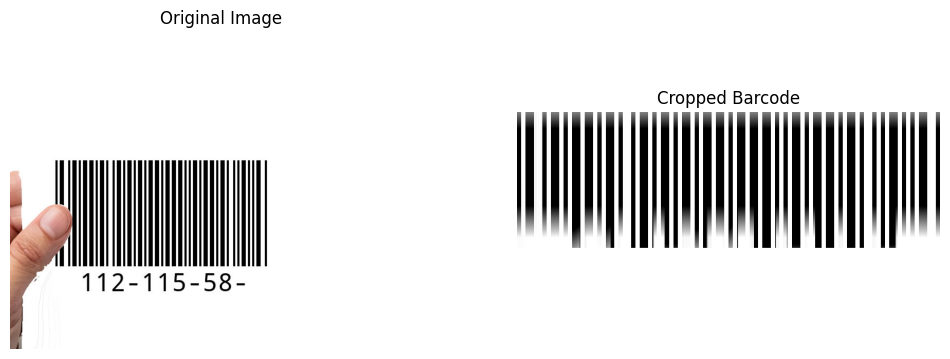

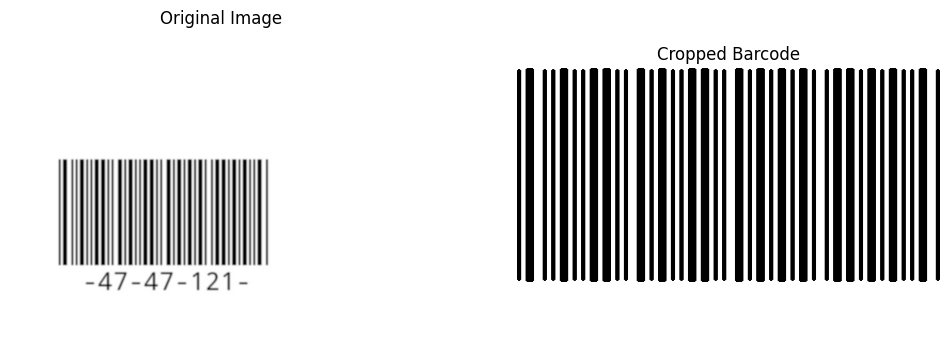

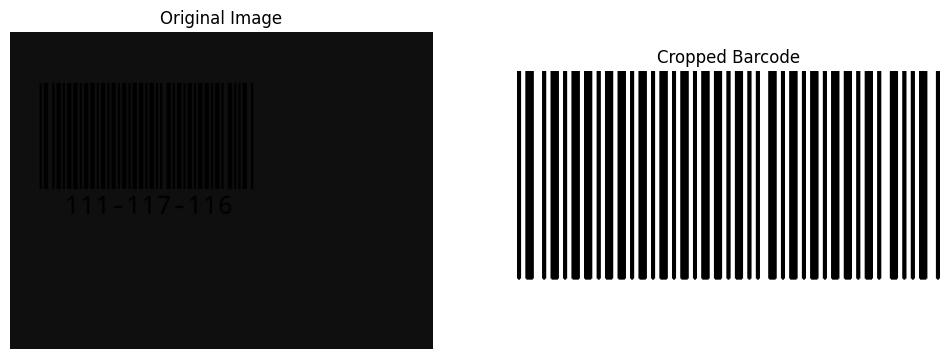

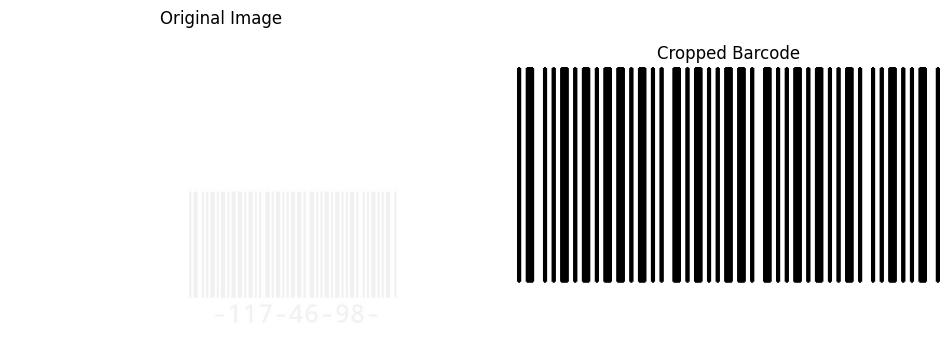

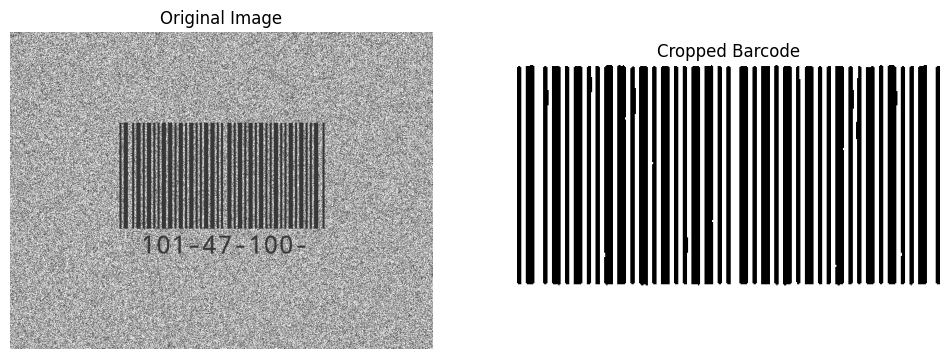

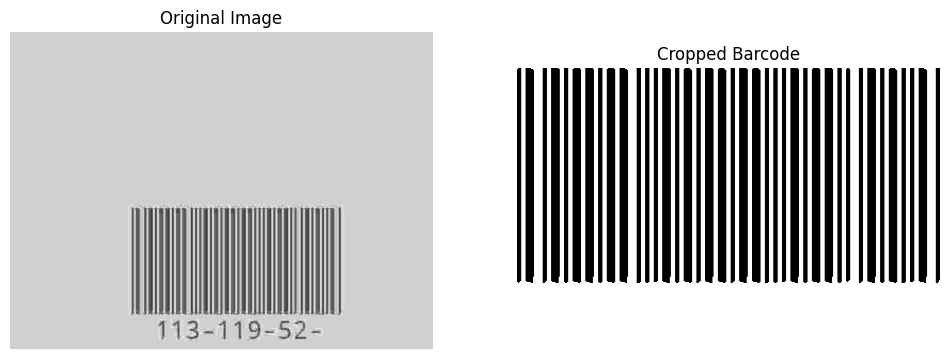

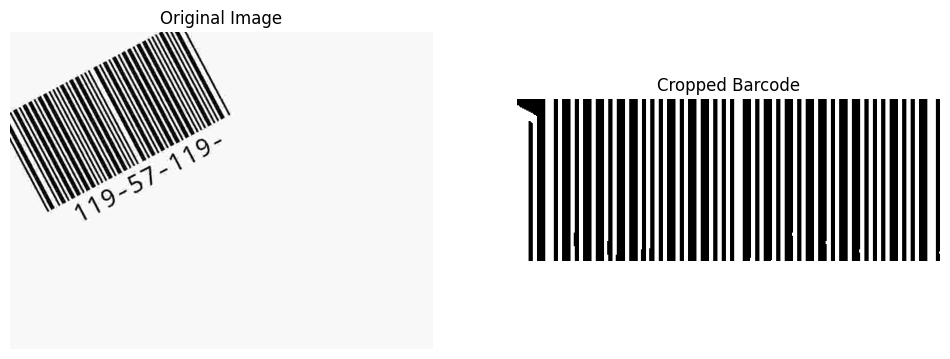

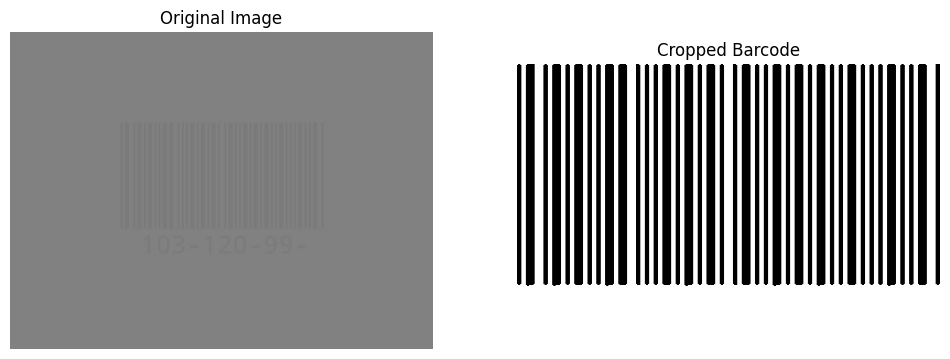

Image contains sine wave noise


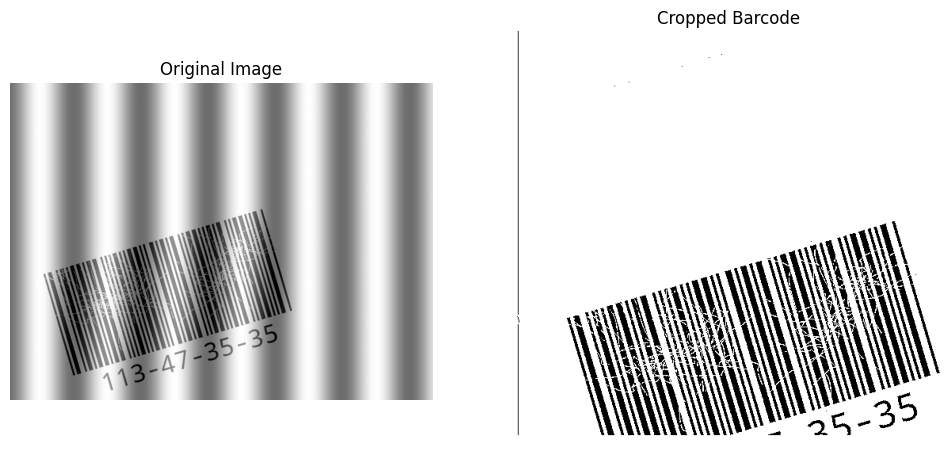

In [52]:
import os
from typing import Optional
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def crop(img: np.ndarray, margin: int = 20) -> np.ndarray:
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)

    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for c in contours:
        x, y, w, h = cv.boundingRect(c)
        aspect_ratio = w / h
        if cv.contourArea(c) > 100 and aspect_ratio < 2:
            filtered_contours.append(c)
    
    if not filtered_contours:
        return img

    x_min = min(cv.boundingRect(c)[0] for c in filtered_contours)
    x_max = max(cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in filtered_contours)
    y_min = min(cv.boundingRect(c)[1] for c in filtered_contours)
    y_max = max(cv.boundingRect(c)[1] + cv.boundingRect(c)[3] for c in filtered_contours)

    barcode_height = y_max - y_min
    y_max = int(y_max - 0.15 * barcode_height)

    cropped_img = img[y_min:y_max, x_min:x_max]

    if margin > 0:
        padded_img = cv.copyMakeBorder(cropped_img, 0, margin, 0, 0, cv.BORDER_CONSTANT, value=255)
    else:
        padded_img = cropped_img

    return padded_img




import cv2 as cv
import numpy as np

def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image by deskewing and removing noise.

    Args:
        image (np.ndarray): Input image.

    Returns:
        np.ndarray: Preprocessed and aligned image.
    """
    img = image.copy()

    # Step 1: Convert to grayscale if needed
    if len(img.shape) == 3:
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Step 2: Thresholding
    _, thresholded = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY_INV)

    # Step 3: Morphological operations to close gaps
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel)

    # Step 4: Find contours and deskew the image if needed
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv.contourArea)
        rect = cv.minAreaRect(largest_contour)
        angle = rect[-1]

        # Adjust angle to correct rotation
        if angle < -45:
            angle += 90

        # Rotate the image if the angle is significant
        if abs(angle - 90) > 1 and abs(angle) > 1:
            (h, w) = img.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv.getRotationMatrix2D(center, angle - 90, 1.0)
            img = cv.warpAffine(img, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
            img_gray = cv.warpAffine(img_gray, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    # Step 5: Apply blurring and denoising
    img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
    _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Step 6: Morphological closing to clean up
    closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))
    img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)

    # Step 7: Detect skin regions and remove if necessary
    if len(image.shape) == 3:  # Only if the input image is BGR
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
        upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
        lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
        upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

        mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
        mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
        skin_mask = cv.bitwise_or(mask1, mask2)

        if cv.countNonZero(skin_mask) > 1000:
            img_denoised = remove_hand(img)
            
    if cv.countNonZero(skin_mask) > 1000:
            img_denoised = remove_hand(img)
    else:
            # sine wave noise
            kernel = cv.getStructuringElement(cv.MORPH_RECT, (50, 1))
            img_dilated = cv.morphologyEx(img_denoised, cv.MORPH_DILATE, kernel)
            if len(np.unique(img_dilated)) > 1:
                print("Image contains sine wave noise")
                img_denoised = cv.adaptiveThreshold(
                    img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
                )

    return img_denoised





# before rotation

# def preprocess_image(image: np.ndarray) -> np.ndarray:
#     img = image.copy()

#     if len(img.shape) == 3:
#         img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     else:
#         img_gray = img

#     img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
#     _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

#     closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))
#     img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)

#     hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

#     lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
#     upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
#     lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
#     upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

#     mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
#     mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
#     skin_mask = cv.bitwise_or(mask1, mask2)

#     if cv.countNonZero(skin_mask) > 1000:
#         img_denoised = remove_hand(img)

#     return img_denoised



# def preprocess_image(image: np.ndarray) -> np.ndarray:
#     img = image.copy()

#     # Step 1: Check for rotation and deskew if necessary
#     if len(img.shape) == 3:
#         img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     else:
#         img_gray = img

#     # Apply edge detection to find the barcode
#     edges = cv.Canny(img_gray, 50, 150, apertureSize=3)
#     lines = cv.HoughLines(edges, 1, np.pi / 180, 200)

#     angle = 0
#     if lines is not None:
#         for rho, theta in lines[0]:
#             angle = np.degrees(theta) - 90  # Calculate rotation angle
#             break

#     # Rotate the image to deskew the barcode only if necessary
#     if abs(angle - 90) > 1 and abs(angle) > 1 and abs(angle) != 0:  # Check if rotation is necessary
#         (h, w) = img_gray.shape
#         center = (w // 2, h // 2)
#         rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
#         img = cv.warpAffine(img, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

#     # Step 2: Convert to grayscale
#     if len(img.shape) == 3:
#         img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     else:
#         img_gray = img

#     # Step 3: Blurring and Thresholding
#     img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
#     _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

#     # Step 4: Morphological Closing
#     closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))
#     img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)

#     return img_denoised




# rotaion  did not work 
# def preprocess_image(image: np.ndarray) -> np.ndarray:
#     img = image.copy()

#     # Step 1: Check for rotation and deskew if necessary
#     if len(img.shape) == 3:
#         img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     else:
#         img_gray = img

#     # Apply edge detection to find the barcode
#     edges = cv.Canny(img_gray, 50, 150, apertureSize=3)
#     lines = cv.HoughLines(edges, 1, np.pi / 180, 200)

#     angle = 0
#     if lines is not None:
#         for rho, theta in lines[0]:
#             angle = np.degrees(theta) - 90  # Calculate rotation angle
#             break

#     # Rotate the image to deskew the barcode only if necessary
#     if abs(angle - 90) > 1 and abs(angle) > 1:  # Check if rotation is necessary
#         (h, w) = img_gray.shape
#         center = (w // 2, h // 2)
#         rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
#         img = cv.warpAffine(img, rotation_matrix, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

#     # Step 2: Convert to grayscale
#     if len(img.shape) == 3:
#         img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     else:
#         img_gray = img

#     # Step 3: Blurring and Thresholding
#     img_blurred = cv.medianBlur(cv.blur(img_gray, (3, 3)), 3)
#     _, img_denoised = cv.threshold(img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

#     # Step 4: Morphological Closing
#     closing_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 7))
#     img_denoised = cv.morphologyEx(img_denoised, cv.MORPH_CLOSE, closing_kernel, iterations=2)

#     # Step 5: Skin Detection
#     hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

#     lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
#     upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
#     lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
#     upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

#     mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
#     mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
#     skin_mask = cv.bitwise_or(mask1, mask2)

#     if cv.countNonZero(skin_mask) > 1000:
#         img_denoised = remove_hand(img)

#     return img_denoised

def remove_hand(img: np.ndarray) -> Optional[np.ndarray]:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
    upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
    lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
    upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

    mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
    mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
    skin_mask = cv.bitwise_or(mask1, mask2)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
    skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

    contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  

    largest_contour = max(contours, key=cv.contourArea)

    hand_mask = np.zeros_like(skin_mask)
    cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)

    hand_mask_inv = cv.bitwise_not(hand_mask)

    img_no_hand = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)

    gray = cv.cvtColor(img_no_hand, cv.COLOR_BGR2GRAY)

    erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 50))
    binary_erode = cv.erode(gray, erosion_kernel, iterations=2)

    dilation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 60))
    binary_opened = cv.dilate(binary_erode, dilation_kernel, iterations=3)

    dilationkernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 10))
    binary_final = cv.dilate(binary_opened, dilationkernel2, iterations=2)

    kernel = np.ones((30, 1), np.float32) / 30
    vertical_mean_filtered = cv.filter2D(binary_final, -1, kernel)

    img = cv.normalize(vertical_mean_filtered, None, 0, 255, cv.NORM_MINMAX)

    return img

def display_before_after(original_img: np.ndarray, cropped_img: np.ndarray, title_before: str = "Original Image", title_after: str = "Cropped Barcode"):
    plt.figure(figsize=(12, 6))
    images = [(original_img, title_before), (cropped_img, title_after)]
    for i, (img, title) in enumerate(images):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis("off")
    plt.show()

def process_test_cases(image_folder: str, special_image_index: Optional[int] = None):
    files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    files.sort(key=lambda x: int(os.path.splitext(x)[0].split()[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        image_path = os.path.join(image_folder, file_name)
        original_img = cv.imread(image_path)
        if original_img is None:
            print(f"Could not read image {file_name}. Skipping...")
            continue

        cleaned_img = preprocess_image(original_img)
        cropped_img = crop(cleaned_img)
        cv.imwrite(os.path.join(output_folder, f"Cropped_{file_name}"), cropped_img)
        display_before_after(original_img, cropped_img)

if __name__ == "__main__":
    folder = r"C:\Users\A\Desktop\CV-main\Test Cases-20241123"
    process_test_cases(folder, special_image_index=7)


In [53]:
def decoder(your_cropped_image):
    """
    Decodes a Code 11 barcode from a cropped image.
    
    Args:
        your_cropped_image (numpy.ndarray): The cropped barcode image in grayscale.
        
    Returns:
        list: Decoded digits as a list of strings, excluding 'Stop/Start'.
    """
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    # Get the average of each column in your image
    mean = your_cropped_image.mean(axis=0)

    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0

    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    for pixel in pixels:
        if pixel == "1":
            narrow_bar_size += 1
        else:
            break

    wide_bar_size = narrow_bar_size * 2

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if count == narrow_bar_size else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            current_digit_widths = ""
            skip_next = True  

    return digits

cropped_image_path_Folder = "C:\\Users\\A\\Desktop\\CV-main\\Test Cases-20241123\\Processed_Output"


cropped_images = sorted(os.listdir(cropped_image_path_Folder))

for cropped_image in cropped_images:
    cropped_image_path = os.path.join(cropped_image_path_Folder, cropped_image)
    cropped_img = cv.imread(cropped_image_path, cv.IMREAD_GRAYSCALE)
    if cropped_img is not None:
        decoded_digits = decoder(cropped_img)
        print("Decoded barcode:", ''.join(decoded_digits))

Decoded barcode: Stop/Start1234567890-Stop/Start
Decoded barcode: Stop/Start104-116-116Stop/Start
Decoded barcode: Stop/Start112-115-58-Stop/Start
Decoded barcode: Stop/Start-47-47-121-Stop/Start
Decoded barcode: Stop/Start111-117-116Stop/Start
Decoded barcode: Stop/Start-117-46-98-Stop/Start
Decoded barcode: Stop/Start101-47-100-Stop/Start
Decoded barcode: Stop/Start113-119-52-Stop/Start
Decoded barcode: 
Decoded barcode: Stop/Start103-120-99-Stop/Start
Decoded barcode: 
